In [1]:
import numpy as np
pi = np.pi

from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import gate_sequence_product, rx, csign
from qutip.qip.device import *
from qutip.qip import pulse

#print(qutip.qip.device.__file__)
import qip.ethprocessor as qip
from qip.ethprocessor import ETHProcessor
%load_ext autoreload
%autoreload 2

# One qubit test

## Create a Quantum Circuit

In [39]:
# Number of qubits in the system
N = 1

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N)

qc.add_gate("RZ", 0, None, np.pi/2, r"\pi/2")
qc.add_gate("RX", 0, None, np.pi/2, r"\pi/2")
qc.add_gate("RZ", 0, None, np.pi/2, r"\pi/2")
#qc.add_gate("RX", 0, None, np.pi/2, r"\pi/2")
#qc.add_gate("RX", 0, None, np.pi/3, r"\pi/3")

#qc.png

### Resulting unitary

In [42]:
U_list = qc.propagators()
U = gate_sequence_product(U_list)
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.-0.70710678j 0.-0.70710678j]
 [0.-0.70710678j 0.+0.70710678j]]

### ETH Processor

In [43]:
eth = ETHProcessor()
tlist, coeffs = eth.load_circuit(qc)

### Plot pulses

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bbb6d29520>)

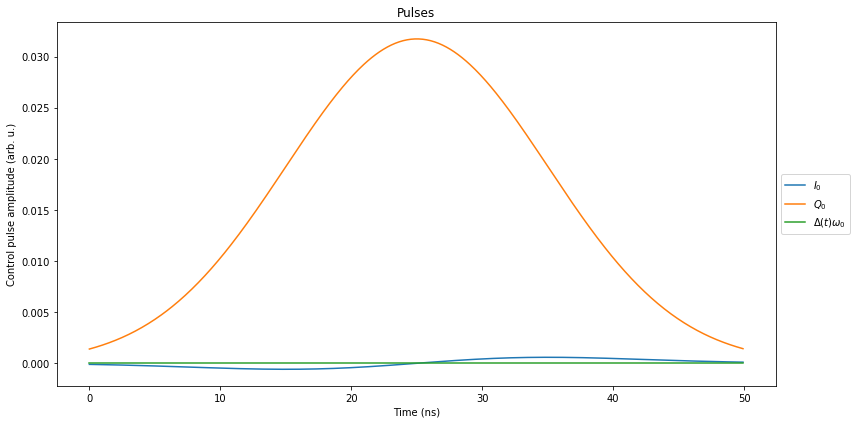

In [44]:
eth.plot_pulses(title='Pulses')

## Execute quantum circuit

In [51]:
result = eth.run_state(init_state = basis(3,0), analytical = False)
final_state = result.states[-1]

### Transform to the transmon frame

In [52]:
H_drift = eth.drift.drift_hamiltonians[0].qobj # Qubit Hamiltonian
t_total = tlist[-1]
U_rot = (1j*H_drift*t_total).expm()
transmon_state = U_rot * final_state

### Project onto qubit subspace

In [54]:
# project onto qubit subspace
qubit_state = Qobj(transmon_state.data[0:2], dims = [[2],[1]])

# target state
U_list = qc.propagators()
U = gate_sequence_product(U_list)

target_state = U*basis(2,0)

# fidelity
fid = fidelity(target_state, qubit_state)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Fidelity = 100.0 %


# Two qubit test
## Quantum Circuit

In [62]:
# Number of qubits in the system
N = 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)

qc.add_gate("RZ", 0, None, np.pi/2, r"\pi")
qc.add_gate("RX", 0, None, np.pi, r"\pi")
qc.add_gate("RX", 1, None, np.pi, r"\pi")
#qc.add_gate("RX", 0, None, np.pi/2, r"\pi/2")
#qc.png

### ETH Processor

In [63]:
from qip.ethprocessor import ETHProcessor
eth = ETHProcessor()
tlist, coeffs = eth.load_circuit(qc)

### Plot pulses

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bbb7528910>)

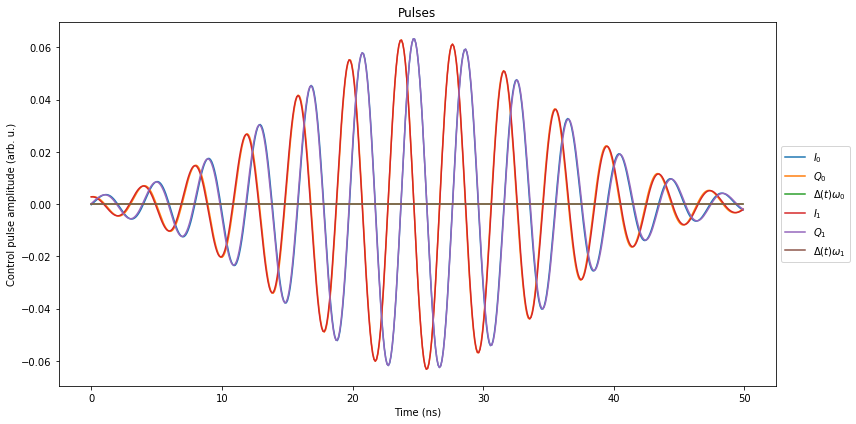

In [64]:
eth.plot_pulses(title='Pulses')

## Run state

In [65]:
psi = tensor(basis(3,0),basis(3,0)) # vacuum
result = eth.run_state(init_state = psi, analytical = False)
final_state = result.states[-1]

### Transform to the transmon frame

In [66]:
H_drift = eth.drift.drift_hamiltonians[0].qobj # Qubit Hamiltonian
t_total = tlist[-1]
U_rot = (1j*H_drift*t_total).expm()
transmon_state = U_rot * final_state

In [67]:
# project onto qubit subspace
qubit_state = (tensor(basis(2,0),basis(2,0))*tensor(basis(3,0),basis(3,0)).dag() \
               + tensor(basis(2,1),basis(2,1))*tensor(basis(3,1),basis(3,1)).dag() \
               + tensor(basis(2,0),basis(2,1))*tensor(basis(3,0),basis(3,1)).dag() \
               + tensor(basis(2,1),basis(2,0))*tensor(basis(3,1),basis(3,0)).dag()) * transmon_state

# target state
U_list = qc.propagators()
target_state = gate_sequence_product(U_list) * tensor(basis(2,0),basis(2,0))

print(target_state)

# fidelity
fid = fidelity(qubit_state,target_state)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.70710678+0.70710678j]]
Fidelity = 99.9446 %


In [68]:
qubit_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-7.21379533e-05+0.00181581j]
 [ 6.31522317e-04-0.00289227j]
 [ 2.90584531e-03-0.00302994j]
 [-7.36119163e-02-0.99700185j]]

## CZ gate

In [18]:
# Number of qubits in the system
N = 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False, input_states = [0] * N)
#qc.add_gate("RX", 0, None, np.pi, r"\pi")
qc.add_gate("CSIGN", controls=0, targets=1)
#qc.png

In [19]:
from qip.ethprocessor import ETHProcessor
eth = ETHProcessor()
tlist, coeffs = eth.load_circuit(qc)

[0.25250501002004005, 0.25250501002004005, 0.25250501002004, 0.2525050100200401, 0.2525050100200401, 0.2525050100200399, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.25250501002003967, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200392, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200401, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.2525050100200392, 0.252505010020041, 0.2525050100200392, 0.2525


499
(6, 499)


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x212479ce490>)

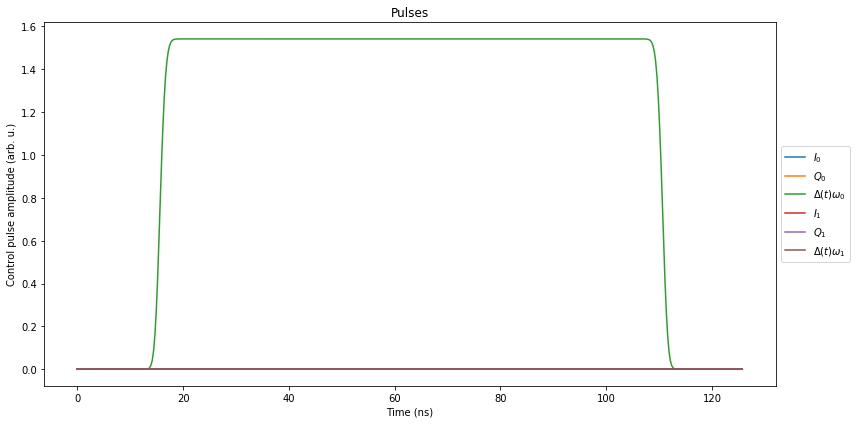

In [20]:
eth.plot_pulses(title='Pulses')

In [21]:
psi = tensor(basis(3,1),basis(3,1)) # vacuum
result = eth.run_state(init_state = psi, analytical=False)
final_state = result.states[-1]

In [22]:
H_drift = eth.drift.drift_hamiltonians[0].qobj # Qubit Hamiltonian
t_total = tlist[-1]
U_rot = (1j*H_drift*t_total).expm()
transmon_state = U_rot * final_state

In [23]:
# project onto qubit subspace
qubit_state = (tensor(basis(2,0),basis(2,0))*tensor(basis(3,0),basis(3,0)).dag() \
               + tensor(basis(2,1),basis(2,1))*tensor(basis(3,1),basis(3,1)).dag() \
               + tensor(basis(2,0),basis(2,1))*tensor(basis(3,0),basis(3,1)).dag() \
               + tensor(basis(2,1),basis(2,0))*tensor(basis(3,1),basis(3,0)).dag()) * transmon_state

# target state
U_list = qc.propagators()
target_state = gate_sequence_product(U_list) * tensor(basis(2,1),basis(2,1))

print(target_state)

# fidelity
fid = fidelity(qubit_state,target_state)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 0.]
 [-1.]]
Fidelity = 99.9639 %


In [24]:
qubit_state

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.22202746-0.97485551j]]